En primer lugar instalamos la librería dataprep para facilitar un análisis exploratorio rápido.

In [1]:
!pip install dataprep

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataprep.eda import create_report
from matplotlib.ticker import StrMethodFormatter

NumExpr defaulting to 2 threads.


Vamos a buscar los datos a un repositorio de github. Estos datos contienen el cambio de temperatura con respecto al año anterior en los distintos países del mundo entre 1961 y el 2020. Luego utilizando la librería dataprep (En particular el método create_report) realizamos un análisis exploratorio de las variables para ver que limpieza necesitamos hacer.

In [3]:
raw_data=pd.read_csv('https://raw.githubusercontent.com/patriciomalleag/Proyectos_Analisis_Varios/master/Temperature_Change/temperature_change_data.csv')
create_report(raw_data)

Output hidden; open in https://colab.research.google.com to view.

Podemos darnos cuenta a priori de 2 cosas:  

1.   Existen países sin subregión. (Eliminaremos estos datos)
2.   Existen países donde no tenemos un dato de cambio en la temperatura (Imputaremos estos datos con el promedio de la región en el periodo respectivo)



In [4]:
raw_data[raw_data['sub_region_name'].isna()]['country'].unique()

array(['Netherlands Antilles (former)', 'Channel Islands',
       'Midway Island', 'Serbia and Montenegro',
       'China, Taiwan Province of', 'Wake Island'], dtype=object)

In [5]:
raw_data = raw_data[raw_data['sub_region_name'].notna()]

In [6]:
raw_grouped = raw_data.groupby(['region_name','sub_region_name','year','month'], as_index = False).agg(
                    sub_region_mean_value = pd.NamedAgg('value','mean')
)
raw_grouped

,region_name,sub_region_name,year,month,sub_region_mean_value
0,Africa,Northern Africa,1961,April,1.092000
1,Africa,Northern Africa,1961,August,-0.109667
2,Africa,Northern Africa,1961,December,1.000833
3,Africa,Northern Africa,1961,February,-0.176667
4,Africa,Northern Africa,1961,January,-0.554833
...,...,...,...,...,...
14395,South America,Latin America and the Caribbean,2020,March,1.951308
14396,South America,Latin America and the Caribbean,2020,May,1.216769
14397,South America,Latin America and the Caribbean,2020,November,1.319077
14398,South America,Latin America and the Caribbean,2020,October,1.680000


In [7]:
raw_grouped.describe()

,year,sub_region_mean_value
count,14400.000000,14028.000000
mean,1990.500000,0.453038
std,17.318704,1.021539
min,1961.000000,-6.657800
25%,1975.750000,-0.078655
50%,1990.500000,0.378000
75%,2005.250000,0.927800
max,2020.000000,6.788200


Habiendo realizado una primera limpieza podemos observar que existen valores que aún siguen vacíos, por lo cual existe una o más regiones completas sin datos en ciertos periodos. Veamos cuales son:

In [8]:
print(raw_grouped[raw_grouped.isna().any(axis=1)]['year'].unique())
print(raw_grouped[raw_grouped.isna().any(axis=1)]['sub_region_name'].unique())

[1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991]
['Central Asia']


Podemos ver que Asia Central no tiene datos desde 1961 hasta 1991, por lo cual eliminaremos todos esos datos y en términos de análisis debemos tener esto en cuenta posteriormente.

In [9]:
corrected_data = pd.merge(raw_data, raw_grouped, how="left", on=['region_name','sub_region_name','year','month'])
corrected_data.value.fillna(corrected_data.sub_region_mean_value, inplace=True)
del corrected_data['sub_region_mean_value']
corrected_data = corrected_data[corrected_data['value'].notna()]
corrected_data['formated_date'] = corrected_data['year'].astype(str) + '-' + corrected_data['month'] + '-01'
corrected_data['formated_date']= pd.to_datetime(corrected_data['formated_date'])

In [10]:
create_report(corrected_data)

Output hidden; open in https://colab.research.google.com to view.

Habiendo ya corregido los datos y observando el nuevo reporte, procedemos a cálcular algunas medidas de interés para nuestro informe.

In [11]:
corrected_data

,fao_code,country,month,year,value,iso_3_code,sub_region_name,region_name,formated_date
0,22,Aruba,January,1961,0.447,ABW,Latin America and the Caribbean,Central America,1961-01-01
1,22,Aruba,January,1962,-0.072,ABW,Latin America and the Caribbean,Central America,1962-01-01
2,22,Aruba,January,1963,0.010,ABW,Latin America and the Caribbean,Central America,1963-01-01
3,22,Aruba,January,1964,0.391,ABW,Latin America and the Caribbean,Central America,1964-01-01
4,22,Aruba,January,1965,-0.628,ABW,Latin America and the Caribbean,Central America,1965-01-01
...,...,...,...,...,...,...,...,...,...
167755,181,Zimbabwe,December,2016,1.298,ZWE,Sub-Saharan Africa,Africa,2016-12-01
167756,181,Zimbabwe,December,2017,0.709,ZWE,Sub-Saharan Africa,Africa,2017-12-01
167757,181,Zimbabwe,December,2018,1.475,ZWE,Sub-Saharan Africa,Africa,2018-12-01
167758,181,Zimbabwe,December,2019,2.322,ZWE,Sub-Saharan Africa,Africa,2019-12-01


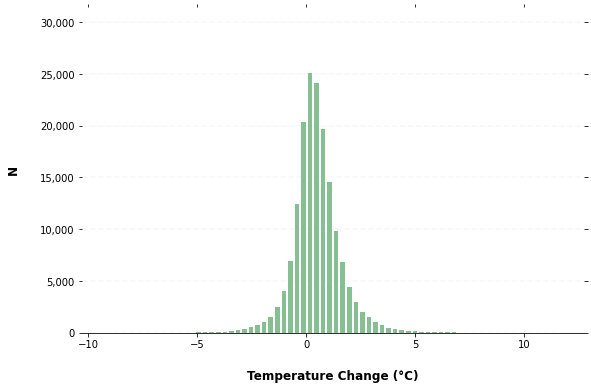

In [12]:
ax = corrected_data.hist(column='value', bins=70, grid=False, figsize=(9,6), color='#86bf91', zorder=2, rwidth=0.7)

ax = ax[0]
for x in ax:
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    x.set_title("")
    x.set_xlabel("Temperature Change (°C)", labelpad=20, weight='bold', size=12)
    x.set_ylabel("N", labelpad=20, weight='bold', size=12)
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [13]:
print(corrected_data['value'].mean())
print(corrected_data['value'].var())

0.47756516580191904
1.2184801733121826


In [14]:
mean_sr = corrected_data.groupby(['year','region_name'], as_index=False).agg(
        t_change_mean = pd.NamedAgg('value','mean')
)

mean_world = corrected_data.groupby(['year'], as_index=False).agg(
        t_change_mean = pd.NamedAgg('value','mean')
)
mean_world['region_name'] = 'World'
mean_world = mean_world[['year','region_name','t_change_mean']]

mean_analysis = pd.concat([mean_sr, mean_world], ignore_index=True, sort=False)

mean_analysis

,year,region_name,t_change_mean
0,1961,Africa,0.003582
1,1961,Antarctica,0.169000
2,1961,Asia,-0.050827
3,1961,Central America,0.010668
4,1961,Europe,0.740469
...,...,...,...
535,2016,World,1.395186
536,2017,World,1.257459
537,2018,World,1.297814
538,2019,World,1.453881


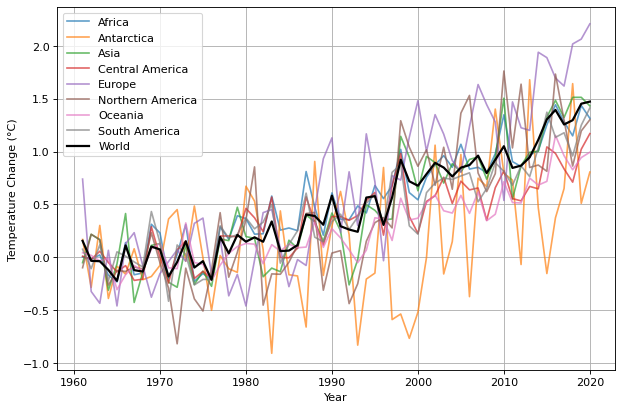

In [15]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=80)
continent_mean = mean_analysis[mean_analysis['region_name']!='World']
world_mean = mean_analysis[mean_analysis['region_name']=='World']
for key, grp in continent_mean.groupby(['region_name']):
    ax = grp.plot(ax=ax, kind='line', x='year', y='t_change_mean', label=key, alpha=0.7)
world_mean.plot(ax=ax, kind='line', x='year', y='t_change_mean', label='World', alpha=1, c='black', linewidth=2.0)
plt.xlabel('Year')
plt.ylabel('Temperature Change (°C)')
plt.grid()
plt.legend(loc='best')
plt.show()

In [16]:
mean_sr_2 = corrected_data[corrected_data['region_name']!='Antarctica'].groupby(['year','region_name'], as_index=False).agg(
        t_change_mean = pd.NamedAgg('value','mean')
)

mean_world_2 = corrected_data[corrected_data['region_name']!='Antarctica'].groupby(['year'], as_index=False).agg(
        t_change_mean = pd.NamedAgg('value','mean')
)

mean_ant_2 = corrected_data[corrected_data['region_name']=='Antarctica'].groupby(['year'], as_index=False).agg(
        t_change_mean = pd.NamedAgg('value','mean')
)

mean_world_2['region_name'] = 'Antarctica'
mean_world_2 = mean_world[['year','region_name','t_change_mean']]

mean_analysis_2 = pd.concat([mean_sr_2, mean_world_2], ignore_index=True, sort=False)

mean_analysis_2

,year,region_name,t_change_mean
0,1961,Africa,0.003582
1,1961,Asia,-0.050827
2,1961,Central America,0.010668
3,1961,Europe,0.740469
4,1961,Northern America,-0.098667
...,...,...,...
475,2016,World,1.395186
476,2017,World,1.257459
477,2018,World,1.297814
478,2019,World,1.453881


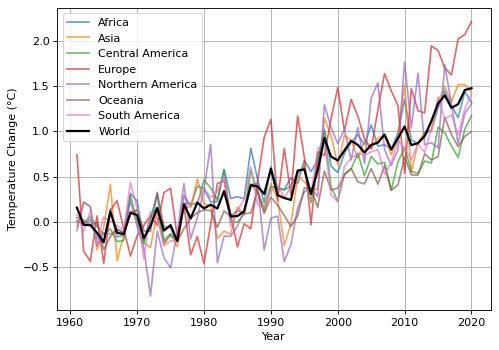

In [17]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=80)
continent_mean_2 = mean_analysis_2[mean_analysis_2['region_name']!='World']
world_mean_2 = mean_analysis_2[mean_analysis_2['region_name']=='World']
for key, grp in continent_mean_2.groupby(['region_name']):
    ax = grp.plot(ax=ax, kind='line', x='year', y='t_change_mean', label=key, alpha=0.7)
world_mean_2.plot(ax=ax, kind='line', x='year', y='t_change_mean', label='World', alpha=1, c='black', linewidth=2.0)
plt.xlabel('Year')
plt.ylabel('Temperature Change (°C)')
plt.grid()
plt.legend(loc='best')
plt.show()

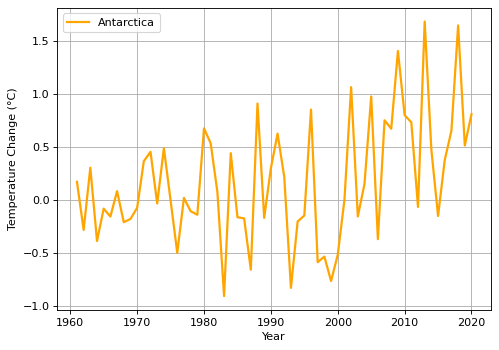

In [18]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=80)
mean_ant_2.plot(ax=ax, kind='line', x='year', y='t_change_mean', label='Antarctica', alpha=1, c='orange', linewidth=2.0)
plt.xlabel('Year')
plt.ylabel('Temperature Change (°C)')
plt.grid()
plt.legend(loc='best')
plt.show()

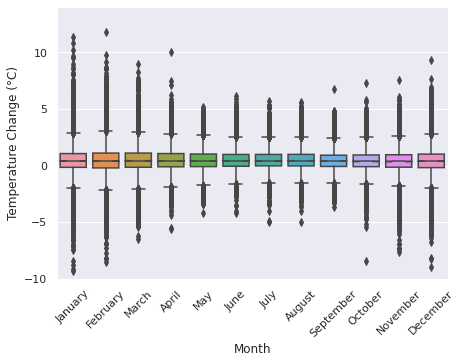

In [19]:
sns.set(rc={'figure.figsize':(7, 5)})
ax = sns.boxplot(x='month',y='value', data=corrected_data, notch=True)
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Temperature Change (°C)')
ax.set_ylim([-10,14])
plt.show()

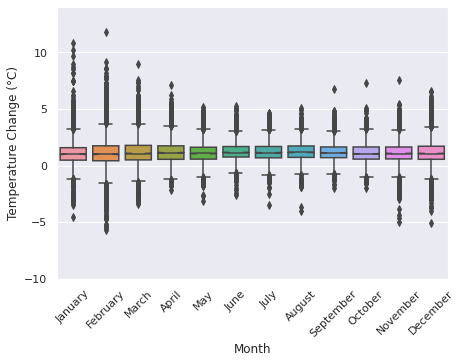

In [20]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(7, 5)})
ax = sns.boxplot(x='month',y='value', data=corrected_data[corrected_data['year']>2010], notch=True)
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Temperature Change (°C)')
ax.set_ylim([-10,14])
plt.show()

In [22]:
monthly_est = corrected_data.groupby(['month']).agg(
    min = pd.NamedAgg('value','min'),
    max = pd.NamedAgg('value','max'),
    mean = pd.NamedAgg('value','mean'),
    var = pd.NamedAgg('value','var'),
)
monthly_est

,min,max,mean,var
month,,,,
April,-5.622,10.049,0.513361,1.092383
August,-4.991,5.576,0.531969,0.828252
December,-8.960,9.306,0.403371,1.518557
February,-8.485,11.759,0.489907,2.199493
January,-9.303,11.332,0.472979,1.844707
July,-5.023,5.709,0.520806,0.809935
June,-4.203,6.167,0.494169,0.804307
March,-6.491,9.012,0.529781,1.621266
May,-4.201,5.213,0.488333,0.932242


In [33]:
country_est = corrected_data.groupby(['region_name','country'],as_index=False).agg(
    min = pd.NamedAgg('value','min'),
    max = pd.NamedAgg('value','max'),
    mean = pd.NamedAgg('value','mean'),
    var = pd.NamedAgg('value','var'),
)
country_est['region_name'].unique()

array(['Africa', 'Antarctica', 'Asia', 'Central America', 'Europe',
       'Northern America', 'Oceania', 'South America'], dtype=object)

In [28]:
country_est[country_est['region_name']=='Africa']

,region_name,country,min,max,mean,var
0,Africa,Algeria,-2.769000,4.297,0.713735,1.455151
1,Africa,Angola,-1.208000,2.958,0.466426,0.437964
2,Africa,Benin,-1.942000,2.205,0.514542,0.442999
3,Africa,Botswana,-2.736000,3.406,0.385040,1.054348
4,Africa,Burkina Faso,-2.427000,3.088,0.564142,0.699265
5,Africa,Burundi,-2.510000,3.236,0.528230,0.453321
6,Africa,C?te d'Ivoire,-1.165000,2.387,0.584565,0.376308
7,Africa,Cabo Verde,-3.621000,3.429,0.659861,0.720102
8,Africa,Cameroon,-1.840000,2.637,0.470304,0.415254
9,Africa,Central African Republic,-2.428000,4.074,0.494145,0.544658


In [35]:
country_est[country_est['region_name']=='Antarctica']

,region_name,country,min,max,mean,var
59,Antarctica,Antarctica,-5.023,6.735,0.175596,2.961009


In [36]:
country_est[country_est['region_name']=='Asia']

,region_name,country,min,max,mean,var
60,Asia,Afghanistan,-7.724000,4.803000,0.477028,2.000437
61,Asia,Armenia,-4.619000,5.612000,0.498759,2.029148
62,Asia,Azerbaijan,-5.448000,5.873000,0.491578,1.881587
63,Asia,Bahrain,-3.620000,4.298000,0.685111,1.663495
64,Asia,Bangladesh,-2.244000,4.015000,0.280190,0.574857
65,Asia,Bhutan,-2.063000,3.321000,0.334689,0.688603
66,Asia,Brunei Darussalam,-1.410000,2.193000,0.363458,0.272739
67,Asia,Cambodia,-2.069000,2.521000,0.410197,0.455907
68,Asia,China,-2.789000,4.381000,0.556936,0.898429
69,Asia,"China, Hong Kong SAR",-4.900000,6.114000,0.401012,1.454907


In [37]:
country_est[country_est['region_name']=='Europe']

,region_name,country,min,max,mean,var
142,Europe,Albania,-4.33400,4.807,0.488378,2.103640
143,Europe,Andorra,-4.55500,5.576,0.690165,2.261534
144,Europe,Austria,-5.30000,5.639,0.787190,3.205983
145,Europe,Belarus,-6.88100,8.136,0.748429,4.651137
146,Europe,Belgium,-5.16800,5.865,0.711431,2.586117
147,Europe,Bosnia and Herzegovina,-4.40900,5.147,0.643431,2.000992
148,Europe,Bulgaria,-5.70900,6.305,0.498722,2.842777
149,Europe,Croatia,-3.93500,4.997,0.685185,1.984228
150,Europe,Czechia,-5.87975,6.206,0.687509,3.358642
151,Europe,Denmark,-6.07600,6.571,0.687628,3.331501


In [38]:
country_est[country_est['region_name']=='Oceania']

,region_name,country,min,max,mean,var
195,Oceania,American Samoa,-1.1830,2.395000,0.421103,0.343282
196,Oceania,Australia,-1.5070,3.127000,0.456219,0.608871
197,Oceania,Christmas Island,-0.9960,2.054000,0.306085,0.300704
198,Oceania,Cocos (Keeling) Islands,-1.1330,2.368000,0.298800,0.340365
199,Oceania,Cook Islands,-1.4660,2.619000,0.320027,0.325824
200,Oceania,Fiji,-1.6610,2.024000,0.286644,0.362930
201,Oceania,French Polynesia,-1.0350,1.466000,0.241639,0.157812
202,Oceania,Kiribati,-0.8310,2.722000,0.272216,0.262046
203,Oceania,Marshall Islands,-0.9465,1.283000,0.124188,0.139257
204,Oceania,Micronesia (Federated States of),-0.9465,1.122000,0.107011,0.125114


In [39]:
country_est[country_est['region_name']=='Central America']  

,region_name,country,min,max,mean,var
110,Central America,Anguilla,-1.204,2.1840,0.297825,0.227101
111,Central America,Antigua and Barbuda,-1.231,2.3870,0.291866,0.231419
112,Central America,Aruba,-1.385,2.0700,0.366462,0.295202
113,Central America,Bahamas,-3.333,3.7740,0.483928,0.679290
114,Central America,Barbados,-1.315,2.2720,0.303368,0.277787
115,Central America,Belize,-2.022,3.9200,0.448199,0.890852
116,Central America,British Virgin Islands,-1.335,1.9800,0.304054,0.253432
117,Central America,Cayman Islands,-2.691,2.9570,0.447579,0.433660
118,Central America,Costa Rica,-1.595,2.4010,0.315276,0.383907
119,Central America,Cuba,-2.223,2.8950,0.510236,0.487873


In [40]:
country_est[country_est['region_name']=='South America']

,region_name,country,min,max,mean,var
220,South America,Argentina,-2.595,3.180,0.265629,0.786741
221,South America,Bolivia (Plurinational State of),-1.969,3.835,0.602629,0.680632
222,South America,Brazil,-1.441,2.298,0.534119,0.367714
223,South America,Chile,-1.474,1.774,0.179915,0.301914
224,South America,Colombia,-1.265,1.944,0.296694,0.272943
225,South America,Ecuador,-1.341,2.318,0.393411,0.370589
226,South America,French Guyana,-0.655,2.455,0.602464,0.496943
227,South America,Guyana,-2.324,2.433,0.515422,0.461695
228,South America,Paraguay,-4.930,3.996,0.376239,1.523420
229,South America,Peru,-1.155,2.208,0.475814,0.324940


In [43]:
country_est[country_est['region_name']=='Northern America']

,region_name,country,min,max,mean,var
190,Northern America,Canada,-6.324,6.138,0.619197,2.625787
191,Northern America,Greenland,-6.338,6.826,0.387688,3.138786
192,Northern America,Mexico,-1.580,2.632,0.372482,0.474065
193,Northern America,Saint Pierre and Miquelon,-5.446,4.699,0.187500,2.029944
194,Northern America,United States of America,-3.513,3.828,0.469719,0.964239


In [115]:
country_est.sort_values(by=['mean'], inplace=True)

mean_analysis_3_min = country_est.head(10)
country_list = list(mean_analysis_3_min['country'].unique())
mean_analysis_3_min  = corrected_data[corrected_data['country'].isin(country_list)]

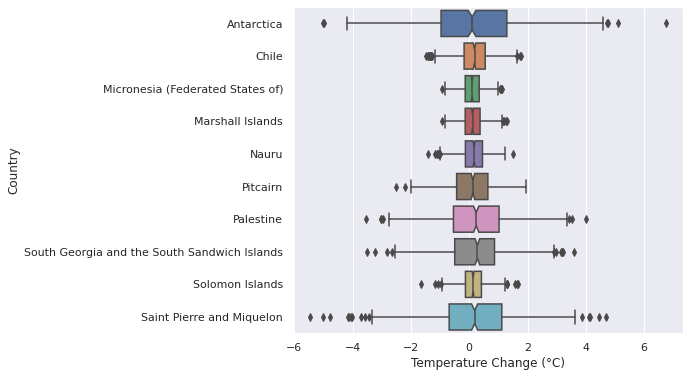

In [116]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(7, 6)})
ax = sns.boxplot(y='country',x='value', data=mean_analysis_3_min, orient='h', notch=True)
plt.xlabel('Temperature Change (°C)')
plt.ylabel('Country')
plt.show()

In [117]:
country_est.sort_values(by=['mean'], inplace=True)

mean_analysis_3_max = country_est.tail(10)
country_list = list(mean_analysis_3_max['country'].unique())
mean_analysis_3_max  = corrected_data[corrected_data['country'].isin(country_list)]

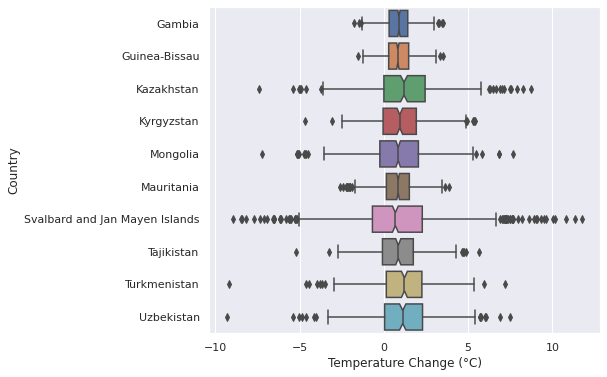

In [118]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(7, 6)})
ax = sns.boxplot(y='country',x='value', data=mean_analysis_3_max, orient='h', notch=True)
plt.xlabel('Temperature Change (°C)')
plt.ylabel('Country')
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(7, 5)})
ax = sns.boxplot(x='month',y='value', data=corrected_data[corrected_data['year']>2010], orient='h', notch=True)
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Temperature Change (°C)')
ax.set_ylim([-10,14])
plt.show()